# TODO

- [x] results match probmods.org
- [ ] plots for observed_luminance section look weird
- [ ] images
- [ ] `expectation(..)`
- [ ] replace WebPPL refs with Pyro

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pyro
import pyro.distributions as dist
pyro.enable_validation()

from pmc_webppl import (
    flip, pflip, repeat, memoize, 
    factor, cond_var, condition, expectation, 
    Infer, viz, viz_heatmap)

# From *A Priori* Dependence to Conditional Dependence

The relationships between causal structure and statistical dependence become particularly interesting and subtle when we look at the effects of additional observations or assumptions.

Events that are statistically dependent *a priori* may become independent when we condition on some observation; this is called *screening off*.

Also, events that are statistically independent *a priori* may become dependent when we condition on observations; this is known as *explaining away*.
The dynamics of screening off and explaining away are extremely important for understanding patterns of inference---reasoning and learning---in probabilistic models.

## Screening off

*Screening off* refers to a pattern of statistical inference that is quite common in both scientific and intuitive reasoning.
If the statistical dependence between two events A and B is only indirect, mediated strictly by one or more other events C, then conditioning on (observing) C should render A and B statistically independent.
This can occur if A and B are connected by one or more causal chains, and all such chains run through the set of events C, or if C comprises all of the common causes of A and B.

For instance, let's look again at our common cause example, this time assuming that we *already* know the value of `C`:

tensor(1.) tensor(1.)
tensor(1.) tensor(0.)
tensor(1.) tensor(1.)
tensor(1.) tensor(0.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.)


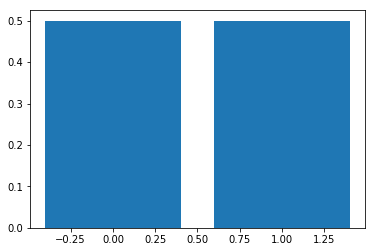

tensor(1.) tensor(1.)
tensor(1.) tensor(0.)
tensor(1.) tensor(1.)
tensor(1.) tensor(0.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.)
tensor(0.) tensor(1.)
tensor(0.) tensor(0.)


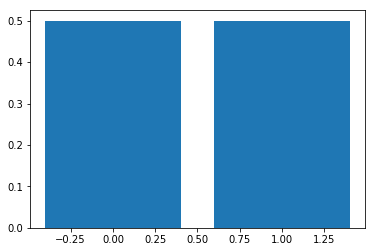

In [9]:
def B_cond_A(A_val):
    def model():
        C = pflip('C', .5)
        B = pflip('B', .5) if C else pflip('B', .9)
        A = pflip('A', .1) if C else pflip('A', .4)
        condition('C_true', bool(C))
        condition('A_val', bool(A) == A_val)
        print(C, A)
        return B
    return Infer(model)  # enumerate
    

viz(B_cond_A(True))
viz(B_cond_A(False))

We see that `A` an `B` are statistically *independent* given knowledge of `C`.

Screening off is a purely statistical phenomenon.
For example, consider the the causal chain model, where A directly causes C, which in turn directly causes B.
Here, when we observe C -- the event that mediates an *indirect* causal relation between A and B -- A and B are still causally dependent in our model of the world: it is just our beliefs about the states of A and B that become uncorrelated.

There is also an analogous causal phenomenon.
If we can actually manipulate or *intervene* on the causal system, and set the value of C to some known value, then A and B become both statistically and causally independent (by intervening on C, we break the causal link between A and C).

## Explaining away

"Explaining away" [@Pearl1988] refers to a complementary pattern of statistical inference which is somewhat more subtle than screening off.

If two events A and B are statistically (and hence causally) independent, but they are both causes of one or more other events C, then conditioning on (observing) C can render A and B statistically dependent.
Here is an example where `A` and `B` have a common *effect*:

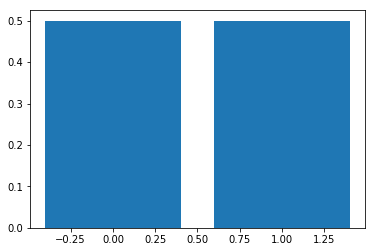

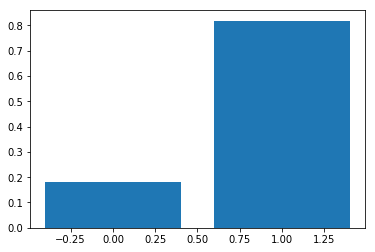

In [20]:
def B_cond_A(A_val):
    def model():
        A = pflip('A', .5)
        B = pflip('B', .5)
        C = pflip('C', (.9 if (A or B) else .2))
        condition('C_true', bool(C))
        condition('A_val', bool(A) == A_val)
        return B
    return Infer(model)  # enumerate
    

viz(B_cond_A(True))
viz(B_cond_A(False))

As with screening off, we only induce statistical dependence from learning about `C`, not causal dependence: when we observe `C`, `A` and `B` remain causally independent in our model of the world; it is our beliefs about A and B that become correlated.

<!--
This is an important point, but I'm not sure how to work it in. It should also be made more general, beyond linguistics:
In models in cognitive science in general and linguistics in particular this kind of independence is often reflected in a certain *modularity* in the system. For instance, in generative models of language it is often assumed that phonology and semantics don't interact directly, but only through the syntax.
-->

We can express the general phenomenon of explaining away with the following schematic WebPPL query:

```python
def model():
    a = ...
    b = ...
    data = f(a, b)
    condition('data', bool(data == some_val and a == some_other_val))
    return b

Infer(model)
```

We have defined two independent variables `a` and `b` both of which are used to define the value of our data.
If we condition on `data` and `a` the posterior distribution on `b` will now be dependent on `a`: observing additional information about `a` changes our conclusions about `b`.

The most typical pattern of explaining away we see in causal reasoning is a kind of *anti-correlation*: the probabilities of two possible causes for the same effect increase when the effect is observed, but they are conditionally anti-correlated, so that observing additional evidence in favor of one cause should lower our degree of belief in the other cause.
(This pattern is where the term explaining away comes from.)
However, the coupling induced by conditioning on common effects depends on the nature of the interaction between the causes, it is not always an anti-correlation.
Explaining away takes the form of an anti-correlation when the causes interact in a roughly disjunctive or additive form: the effect tends to happen if any cause happens; or the effect happens if the sum of some continuous influences exceeds a threshold.
The following simple mathematical examples show this and other patterns.

Suppose we condition on observing the sum of two integers drawn uniformly from 0 to 9:

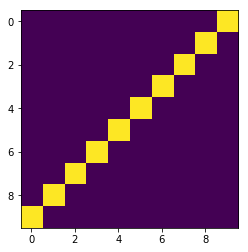

In [147]:
def model():
    A = pyro.sample('A', dist.Categorical(torch.ones(10)))
    B = pyro.sample('B', dist.Categorical(torch.ones(10)))
    condition('AB', bool(A + B == 9))
    return torch.tensor([A, B])

sum_posterior = Infer(model, num_samples=100)


viz_heatmap(sum_posterior)
# TODO: scatter plot

This gives perfect anti-correlation in conditional inferences for `A` and `B`. But suppose we instead condition on observing that `A` and `B` are equal:

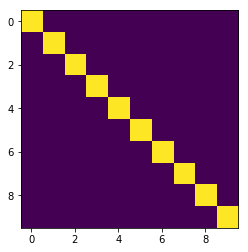

In [149]:
def model():
    A = pyro.sample('A', dist.Categorical(torch.ones(10)))
    B = pyro.sample('B', dist.Categorical(torch.ones(10)))
    condition('AB', bool(A == B))
    return torch.tensor([A, B])


sum_posterior = Infer(model, num_samples=100)


viz_heatmap(sum_posterior)

# plt.title('A')
# viz(sum_posterior[:, 0])
# plt.title('B')
# viz(sum_posterior[:, 1])
# TODO sometimes this scatter plot is easier to interpret:
# viz.scatter(sum_posterior.support())

Now, of course, A and B go from being independent a priori to being perfectly correlated in the conditional distribution.
Try out these other conditions to see other possible patterns of conditional dependence for *a priori* independent functions:

* `abs(A - B) < 2`
* `(A + B >= 9) and (A + B <= 11)`
* `abs(A - B) == 3`
* `(A - B) % 10 == 3` (Note: `%` means "remainder when divided by...")
* `A % 2 == B % 2`
* `A % 5 == B % 5`

## Non-monotonic Reasoning

One reason explaining away is an important phenomenon in probabilistic inference is that it is an example of *non-monotonic* reasoning.

In formal logic, a theory is said to be monotonic if adding an assumption (or formula) to the theory never reduces the set of conclusions that can be drawn.

Most traditional logics (e.g.
First Order) are monotonic, but human reasoning does not seem to be.
For instance, if I tell you that Tweety is a bird, you conclude that he can fly; if I now tell you that Tweety is an *ostrich* you retract the conclusion that he can fly.

Over the years many non-monotonic logics have been introduced to model aspects of human reasoning.
One of the first reasons that probabilistic reasoning with Bayesian networks was recognized as important for AI was that it could perspicuously capture these patterns of reasoning [see for instance @Pearl1988].

<br>

Another way to think about monotonicity is by considering the trajectory of our belief in a specific proposition, as we gain additional relevant information.

In traditional logic, there are only three states of belief: true, false, and unknown (when neither a proposition nor its negation can be proven).
As we learn more about the world, maintaining logical consistency requires that our belief in any proposition only move from unknown to true or false.
That is our "confidence" in any conclusion only increases (and only does so in one giant leap from unknown to true or false).

In a probabilistic approach, by contrast, belief comes in a whole spectrum of degrees.
We can think of confidence as a measure of how far our beliefs are from a uniform distribution---how close to the extremes of 0 or 1.

In probabilistic inference, unlike in traditional logic, our confidence in a proposition can both increase and decrease.
Even fairly simple probabilistic models can induce complex explaining-away dynamics that lead our degree of belief in a proposition to reverse directions multiple times as observations accumulate.

## Example: Medical Diagnosis

The medical scenario is a great model to explore screening off and explaining away.
In this model `smokes` is statistically dependent on several symptoms---`cough`, `chest_pain`, and `shortness_of_breath`---due to a causal chain between them mediated by `lung_disease`.
We can see this easily by conditioning on these symptoms and looking at `smokes`:

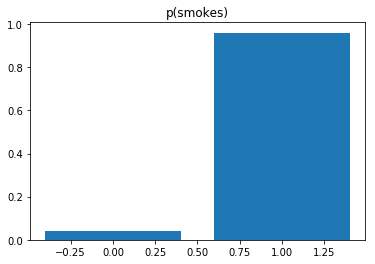

In [3]:
def model():
    smokes = pflip('smokes', 0.2)
    lung_disease = ((smokes and pflip('smokes_ld', 0.1)) or 
                    pflip('ld', 0.001))
    cold = pflip('cold', 0.02)
    
    cough = ((cold and pflip('ld_cold', 0.5)) or
             (lung_disease and pflip('ld_cough', 0.5)) or 
             pflip('cough', 0.001))
    fever = ((cold and pflip('cold_fever', 0.3)) or 
             pflip('fever', 0.01))
    chest_pain = ((lung_disease and pflip('ld_chest_pain', 0.2)) or 
                  pflip('chest_pain', 0.01))
    shortness_of_breath = ((lung_disease and pflip('ld_breath', 0.2)) or 
                           pflip('breath', 0.01))
    
    condition('symptoms', bool(cough and chest_pain and shortness_of_breath))

    return torch.tensor([smokes])

d = Infer(model, num_samples=1000)
viz(d, title='p(smokes)')

The conditional probability of `smokes` is much higher than the base rate, 0.2, because observing all these symptoms gives strong evidence for smoking.
See how much evidence the different symptoms contribute by dropping them out of the conditioning set. (For instance, try conditioning on `cough and chest_pain`, or just `cough`; you should observe the probability of `smokes` decrease as fewer symptoms are observed.)

Now, suppose we condition also on knowledge about the function that mediates these causal links: `lung_disease`.
Is there still an informational dependence between these various symptoms and `smokes`?  In the Inference below, try adding and removing various symptoms (`cough`, `chest_pain`, `shortness_of_breath`) but maintaining the observation `lung_disease`:

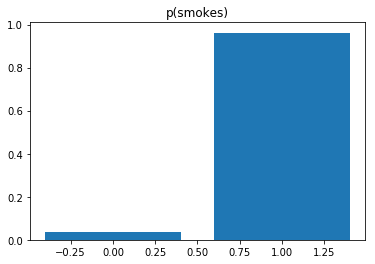

In [4]:

def model():
    smokes = pflip('smokes', 0.2)
    lung_disease = ((smokes and pflip('smokes_ld', 0.1)) or 
                    pflip('ld', 0.001))
    cold = pflip('cold', 0.02)
    
    cough = ((cold and pflip('ld_cold', 0.5)) or
             (lung_disease and pflip('ld_cough', 0.5)) or 
             pflip('cough', 0.001))
    fever = ((cold and pflip('cold_fever', 0.3)) or 
             pflip('fever', 0.01))
    chest_pain = ((lung_disease and pflip('ld_chest_pain', 0.2)) or 
                  pflip('chest_pain', 0.01))
    shortness_of_breath = ((lung_disease and pflip('ld_breath', 0.2)) or 
                           pflip('breath', 0.01))
    
    condition('symptoms', bool(
        lung_disease and cough and chest_pain and shortness_of_breath))

    return torch.tensor([smokes])

d = Infer(model, num_samples=1000)
viz(d, title='p(smokes)')


You should see an effect of whether the patient has lung disease on conditional inferences about smoking---a person is judged to be substantially more likely to be a smoker if they have lung disease than otherwise---but there are no separate effects of chest pain, shortness of breath, or cough over and above the evidence provided by knowing whether the patient has lung-disease.
The intermediate variable lung disease *screens off* the root cause (smoking) from the more distant effects (coughing, chest pain and shortness of breath).

Here is a concrete example of explaining away in our medical scenario.
Having a cold and having lung disease are *a priori* independent both causally and statistically.
But because they are both causes of coughing if we observe `cough` then `cold` and `lung_disease` become statistically dependent.
That is, learning something about whether a patient has `cold` or `lung_disease` will, in the presence of their common effect `cough`, convey information about the other condition. `cold` and `lungCancer` are *a priori* independent, but *conditionally dependent* given `cough`.

To illustrate, observe how the probabilities of `cold` and `lung_disease` change when we observe `cough` is true:

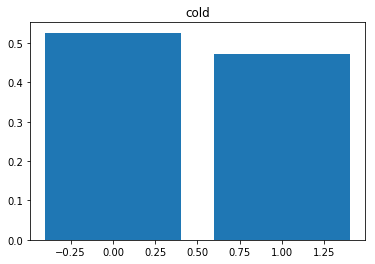

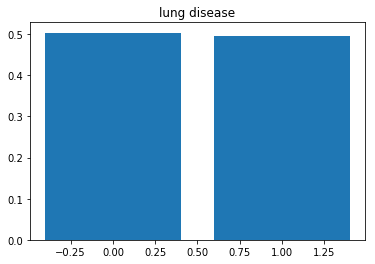

In [2]:
def model():
    smokes = pflip('smokes', 0.2)
    lung_disease = ((smokes and pflip('smokes_ld', 0.1)) or 
                    pflip('ld', 0.001))
    cold = pflip('cold', 0.02)
    cough = ((cold and pflip('ld_cold', 0.5)) or
             (lung_disease and pflip('ld_cough', 0.5)) or 
             pflip('cough', 0.001))
    fever = ((cold and pflip('cold_fever', 0.3)) or 
             pflip('fever', 0.01))
    chest_pain = ((lung_disease and pflip('ld_chest_pain', 0.2)) or 
                  pflip('chest_pain', 0.01))
    shortness_of_breath = ((lung_disease and pflip('ld_breath', 0.2)) or 
                           pflip('breath', 0.01))

    return torch.tensor([cold, lung_disease])


conditioned_model = pyro.condition(model, data={"cough": torch.Tensor([1])})

d = Infer(lambda: conditioned_model()[0])
viz(d, title='cold')
d = Infer(lambda: conditioned_model()[1])
viz(d, title='lung disease')

Both cold and lung disease are now far more likely that their baseline probability: the probability of having a cold increases from 2% to around 50%; the probability of having lung disease also increases from 2.1% to around 50%.

Now suppose we *also* learn that the patient does *not* have a cold.

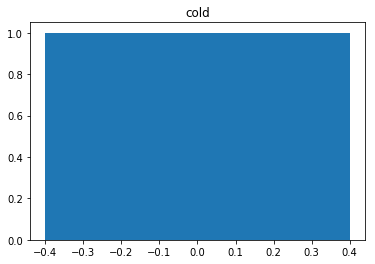

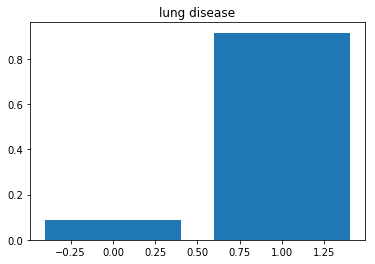

In [4]:
conditioned_model = pyro.condition(model, data={"cough": torch.Tensor([1]),
                                                "cold": torch.Tensor([0])})

d = Infer(lambda: conditioned_model()[0])
viz(d, title='cold')
d = Infer(lambda: conditioned_model()[1])
viz(d, title='lung disease')

The probability of having lung disease increases dramatically.
If instead we had observed that the patient does have a cold, the probability of lung cancer returns to its base rate of 2.1%

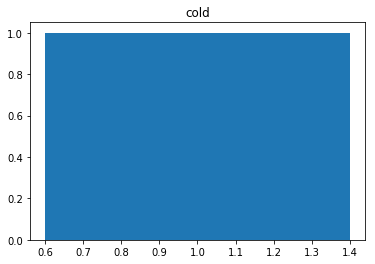

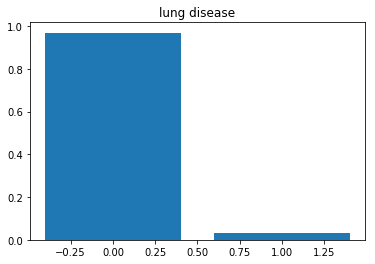

In [5]:
conditioned_model = pyro.condition(model, data={"cough": torch.Tensor([1]),
                                                "cold": torch.Tensor([1])})

d = Infer(lambda: conditioned_model()[0])
viz(d, title='cold')
d = Infer(lambda: conditioned_model()[1])
viz(d, title='lung disease')

This is the conditional statistical dependence between lung disease and cold, given cough: Learning that the patient does in fact have a cold "explains away" the observed cough, so the alternative of lung disease decreases to a much lower value --- roughly back to its 1 in a 1000 rate in the general population.
If on the other hand, we had learned that the patient does not have a cold, so the most likely alternative to lung disease is *not* in fact available to "explain away" the observed cough, that raises the conditional probability of lung disease dramatically.
As an exercise, check that if we remove the observation of coughing, the observation of having a cold or not has no influence on our belief about lung disease; this effect is purely conditional on the observation of a common effect of these two causes.

<!--
Consider now a patient with a cough who also smokes, you will find that cold and lung disease are roughly equally likely explanations.
Or add the observation that the patient has chest pain, so lung disease becomes an even more probable condition than having a cold. These are the settings where explaining away effects will be strongest. Modify the above program to observe that the patient either has a cold or does not have a cold, in addition to having a cough, smoking, and perhaps having chest-pain.

E.g., compare these conditioners:
  (and smokes cough) with (and smokes cough cold) or
                          (and smokes cough (not cold))

  (and smokes chest-pain cough) with (and smokes chest-pain cough cold) or
                                     (and smokes chest-pain cough (not cold))

Notice how far up or down knowledge about whether the patient has a cold can push the conditional belief in having lung disease.
-->

Explaining away effects can be more indirect.
Instead of observing the truth value of `cold`, a direct alternative cause of `cough`, we might simply observe another symptom that provides evidence for `cold`, such as `fever`.
Compare these conditions using the above WebPPL program to see an "explaining away" conditional dependence in belief between `fever` and `lung_disease`.

<!--
Replace `(and smokes chest_pain cough)`  with `(and smokes chest-pain cough fever)` or `(and smokes chest-pain cough (not fever))`.
In this case, finding out that the patient either does or does not have a fever makes a crucial difference in whether we think that the patient has lung disease...
even though fever itself is not at all diagnostic of lung disease, and there is no causal connection between them.
-->

# Example: Trait Attribution

A familiar example of rich patterns of inference comes from reasoning about the causes of students' success and failure in the classroom.
Imagine yourself in the position of an interested outside observer---a parent, another teacher, a guidance counselor or college admissions officer---in thinking about these conditional inferences.
If a student doesn't pass an exam, what can you say about why he failed?  Maybe he doesn't do his homework, maybe the exam was unfair, or maybe he was just unlucky?

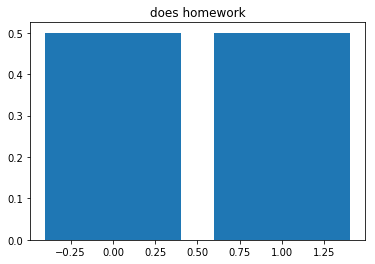

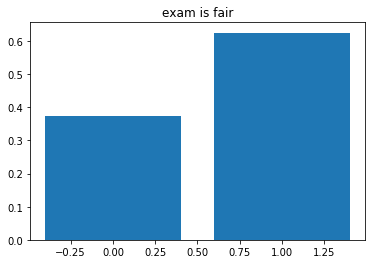

In [6]:
def model():
    exam_fair = pflip('exam_fair', .8)
    does_homework = pflip('does_homework', .8)
    pass_exam = pflip('pass_exam',
        (0.9 if does_homework else 0.4) 
        if exam_fair else
        (0.6 if does_homework else 0.2)
    )
    return torch.tensor([does_homework, exam_fair])


conditioned_model = pyro.condition(model, data={"pass_exam": torch.Tensor([0])})

d = Infer(lambda: conditioned_model()[0])
viz(d, title='does homework')
d = Infer(lambda: conditioned_model()[1])
viz(d, title='exam is fair')

Now what if you have evidence from several students and several exams? We first re-write the above model to allow many students and exams:

In [11]:
exam_fair_ = memoize(lambda exam: pflip(f'{exam}_exam_fair', 0.8))
exam_fair_('blah')

tensor(1.)

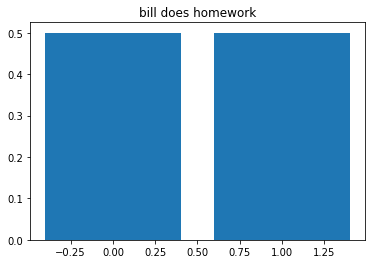

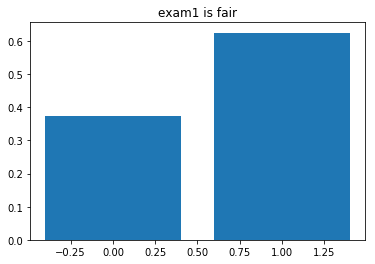

In [3]:
def model():
    exam_fair = memoize(lambda exam: pflip(f'{exam}_exam_fair', 0.8))
    does_homework = memoize(lambda student: pflip(f'{student}_does_homework', 0.8))

    def pass_exam(student, exam):
        return pflip(f'{student}_pass',
            ((0.9 if does_homework(student) else 0.4) 
            if exam_fair(exam) else
            (0.6 if does_homework(student) else 0.2))
        )

    condition('bill_no_pass', bool(not pass_exam('bill', 'exam1')))

    return torch.tensor([does_homework('bill'), exam_fair('exam1')])


d = Infer(lambda: model()[0])
viz(d, title='bill does homework')
d = Infer(lambda: model()[1])
viz(d, title='exam1 is fair')

Initially we observe that Bill failed exam 1.
A priori, we assume that most students do their homework and most exams are fair, but given this one observation it becomes somewhat likely that either the student didn't study or the exam was unfair.

Notice that we have set the probabilities in the `pass` function to be asymmetric: whether a student does homework has a greater influence on passing the test than whether the exam is fair.
This in turns means that when inferring the *cause* of a failed exam, the model tends to attribute it to the person property (not doing homework) over the situation property (exam being unfair).
This asymmetry is an example of the *fundamental attribution bias* [@Ross1977]: we tend to attribute outcomes to personal traits rather than situations.
However there are many interacting tendencies (for instance the direction of this bias switches for members of some east-asian cultures).
How could you extend the model to account for these interactions?

See how conditional inferences about Bill and exam 1 change as you add in more data about this student or this exam, or additional students and exams.
Try using each of the below expressions as the condition for the above inference.
Try to explain the different inferences that result at each stage.
What does each new piece of the larger data set contribute to your intuition about Bill  and exam 1?

* `!pass('bill', 'exam1') and !pass('bill', 'exam2')`

* `!pass('bill', 'exam1') and !pass('mary', 'exam1') and !pass('tim', 'exam1')`

* `!pass('bill', 'exam1') and !pass('bill', 'exam2') and
  !pass('mary', 'exam1') and
  !pass('tim', 'exam1')`

* `!pass('bill', 'exam1') and
  !pass('mary', 'exam1') and pass('mary', 'exam2') and pass('mary', 'exam3') and pass('mary', 'exam4') and pass('mary', 'exam5') and
  !pass('tim', 'exam1') and pass('tim', 'exam2') and pass('tim', 'exam3') and pass('tim', 'exam4') and pass('tim', 'exam5')`

* `!pass('bill', 'exam1') and
  pass('mary', 'exam1') and
  pass('tim', 'exam1')`

* `!pass('bill', 'exam1') and
  pass('mary', 'exam1') and pass('mary', 'exam2') and pass('mary', 'exam3') and pass('mary', 'exam4') and pass('mary', 'exam5') and
  pass('tim', 'exam1') and pass('tim', 'exam2') and pass('tim', 'exam3') and pass('tim', 'exam4') and pass('tim', 'exam5')`

* !`pass('bill', 'exam1') and !pass('bill', 'exam2') and
  pass('mary', 'exam1') and pass('mary', 'exam2') and pass('mary', 'exam3') and pass('mary', 'exam4') and pass('mary', 'exam5') and
  pass('tim', 'exam1') and pass('tim', 'exam2') and pass('tim', 'exam3') and pass('tim', 'exam4') and pass('tim', 'exam5')`

* `!pass('bill', 'exam1') and !pass('bill', 'exam2') and pass('bill', 'exam3') and pass('bill', 'exam4') and pass('bill', 'exam5') and
  pass('mary', 'exam1') and pass('mary', 'exam2') and pass('mary', 'exam3') and pass('mary', 'exam4') and pass('mary', 'exam5') and
  pass('tim', 'exam1') and pass('tim', 'exam2') and pass('tim', 'exam3') and pass('tim', 'exam4') and pass('tim', 'exam5')`


This example is inspired by the work of Harold Kelley (and many others) on causal attribution in social settings [@Kelley1973].
Kelley identified three important dimensions of variation in the evidence, which affect the attributions people make of the cause of an outcome.
These three dimensions are: Persons---is the outcome consistent across different people in the situation?; Entities---is the outcome consistent for different entities in the situation?; Time---is the outcome consistent over different episodes? These dimensions map onto the different sets of evidence we have just seen---how?

<!--- wikipedia:
1) Consistency: "Is the behavior consistent across most people in the given situation?" 2) Distinctiveness: "Does the behavior vary across different situations?" and 3) Consensus: "Do most people engage in this behavior in this situation?"
--->

As in this example, people often have to make inferences about entities and their interactions.
Such problems tend to have dense relations between the entities, leading to very challenging explaining away problems.
These inferences often come very naturally to people, yet they are computationally difficult.
Perhaps these are important problems that our brains have specialized somewhat to solve, or perhaps that they have evolved general solutions to these tough inferences. What do you think?

# Example: Of Blickets and Blocking

A number of researchers have explored children's causal learning abilities by using the "blicket detector" [@Gopnik2000]: a toy box that will light up when certain blocks, the blickets, are put on top of it.
Children are shown a set of evidence and then asked which blocks are blickets.

For instance, if block A makes the detector go off, it is probably a blicket.
Ambiguous patterns are particularly interesting.

Imagine that blocks A and B are put on the detector together, making the detector go off; it is fairly likely that A is a blicket.
Now B is put on the detector alone, making the detector go off; it is now less plausible that A is a blicket.
This is called "backward blocking", and it is an example of explaining away.

We can capture this set up with a model in which each block has a persistent "blicket-ness" property, and the causal power of the block to make the machine go off depends on its blicketness.
Finally, the machine goes off if any of the blocks on it is a blicket (but noisily).

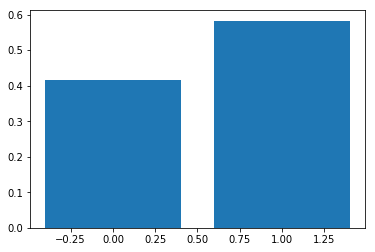

In [7]:
def model():
    blicket = memoize(lambda block: pflip(f'{block}_blicket', .4))
    power = lambda block: .9 if blicket(block) else .05
    def machine(blocks):
        return (
            pflip(f'{blocks}_ machine', .05) 
            if len(blocks) == 0 else
            (pflip(f'{blocks}_ machine', power(blocks[0])) or 
             machine(blocks[1:])))
    
    condition('AB', machine(['A', 'B']))
    # condition('B', machine(['B']))         # uncomment to see explaining away!
    return torch.tensor([blicket('A')])

viz(Infer(model))  # enumerate

Try the backward blocking scenario described above.
@Sobel2004 tried this with children, finding that four year-olds perform similarly to the model: evidence that B is a blicket explains away the evidence that A and B made the detector go away.

# A Case Study in Modularity: Visual Perception of Surface Color

Visual perception is full of rich conditional inference phenomena, including both screening off and explaining away.
Some very impressive demonstrations have been constructed using the perception of surface structure by mid-level vision researchers; see the work of Dan Kersten, David Knill, Ted Adelson, Bart Anderson, Ken Nakayama, among others.

Most striking is when conditional inference appears to violate or alter the apparently "modular" structure of visual processing.
Neuroscientists have developed an understanding of the primate visual system in which processing for different aspects of visual stimuli---color, shape, motion, stereo---appears to be at least somewhat localized in different brain regions.

This view is consistent with findings by cognitive psychologists that at least in early vision, these different stimulus dimensions are not integrated but processed in a sequential, modular fashion.
Yet vision is at heart about constructing a unified and coherent percept of a three-dimensional scene from the patterns of light falling on our retinas.
That is, vision is causal inference on a grand scale.
Its output is a rich description of the objects, surface properties and relations in the world that are not themselves directly grasped by the brain but that are the true causes of the input---low-level stimulation of the retina.

Solving this problem requires integration of many appearance features across an image, and this results in the potential for massive effects of explaining away and screening off.

In vision, the luminance of a surface depends on two factors, the illumination of the surface (how much light is hitting it) and its intrinsic reflectance.
The actual luminance is the product of the two factors.
Thus luminance is inherently ambiguous.

The visual system has to determine what proportion of the luminance is due to reflectance and what proportion is due to the illumination of the scene.
This has led to a famous illusion known as the *checker shadow illusion* discovered by Ted Adelson.

<font size="20" color="red">TODO - image</font>

![Are the two squares the same shade of grey?]({{site.baseurl}}/assets/img/Checkershadow_illusion_small.png)

Despite appearances, in the image above both the square labeled A and the square labeled B are actually the same shade of gray.
This can be seen in the figure below where they are connected by solid gray bars on either side.


<font size="20" color="red">TODO - image</font>

![]({{site.baseurl}}/assets/img/Checkershadow_proof_small.png)

The presence of the cylinder is providing evidence that the illumination of square B is actually less than that of square A (because it is expected to cast a shadow).
Thus we perceive square B as having higher reflectance since its luminance is identical to square A and we believe there is less light hitting it.
The following program implements a simple version of this scenario "before" we see the shadow cast by the cylinder.

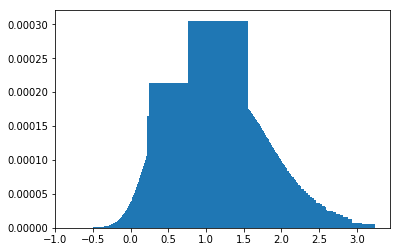

In [4]:
observed_luminance = torch.tensor(3)

def model():
    reflectance = pyro.sample('reflectance', dist.Normal(1, 1))
    illumination = pyro.sample('illumination', dist.Normal(3, 1))  # TODO: pyro.sample?
    luminance = reflectance * illumination
    pyro.sample('luminance', dist.Normal(luminance, 1), obs=observed_luminance)
    return reflectance

reflectance_posterior = Infer(model, posterior_method='MH', num_samples=10000)

# print(expectation(reflectance_posterior))
viz(reflectance_posterior)

Now let's condition on the presence of the cylinder, by conditioning on the presence of its "shadow" (i.e. gaining a noisy observation suggesting that illumination is lower than expected *a priori*):

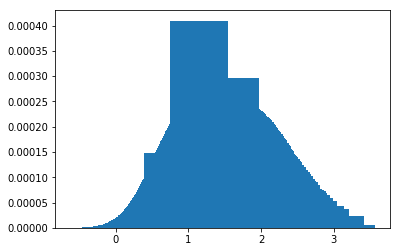

In [5]:
observed_luminance = torch.tensor(3)

def model():
    reflectance = pyro.sample('reflectance', dist.Normal(1, 1))
    illumination = pyro.sample('illumination', dist.Normal(3, 1))  # TODO: pyro.sample?
    luminance = reflectance * illumination
    pyro.sample('luminance', dist.Normal(luminance, 1), obs=observed_luminance)
    pyro.sample('illumination_obs', dist.Normal(illumination, 1), obs=torch.tensor(0.5))
    return reflectance

reflectance_posterior = Infer(model, posterior_method='MH', num_samples=10000)

# print(expectation(reflectance_posterior))
viz(reflectance_posterior)


The variables `reflectance` and `illumination` are conditionally independent in the generative model, but after we condition on `luminance` they become dependent: changing one of them affects the probability of the other.
Although the model of (our knowledge of) the world has a certain kind of modularity implied by conditional independence, as soon as we start using the model to do conditional inference on some data, formerly modularly isolated variables can become dependent.
This general phenomenon has important consequences for cognitive science.

<!--
## Other vision examples (to be developed)
Kersten's [colored Mach card](http://vision.psych.umn.edu/users/kersten/kersten-lab/Mutual_illumination/BlojKerstenHurlbertDemo99.pdf) illusion is a beautiful example of both explaining away and screening off in visual surface perception, as well as a switch between these two patterns of inference conditioned on an auxiliary variable.
Depending on how we perceive the geometry of a surface folded down the middle -- whether it is concave so that the two halves face each other or convex so that they face away -- the perceived colors of the faces will change as the visual system either discounts (explains away) or ignores (screens off) the effects of inter-reflections between the surfaces.

The [two cylinders illusion](http://vision.psych.umn.edu/users/kersten/kersten-lab/images/twocylinders.gif) of Kersten is another nice example of explaining away.
The gray shading patterns are identical in the left and right images, but on the left the shading is perceived as reflectance difference, while on the right (the "two cylinders") the same shading is perceived as due to shape variation on surfaces with uniform reflectance.
-->

<!--

<img src='images/Kersten_et_al_explaining_away.png' width='400' />

(This image is from Kersten, Mamassian and Yuille, Annual Review of Psychology 2004)

model this using simple 1-dim procedural graphics:
   1-dim reflectance (assuming all changes are sharp discrete
   1-dim shape assuming all changes are gradual
   1-dim lighting assuming a gradient with some slope (1 param) falling off across the image, pos
       or neg slope
   Contour is described as either constant or sin function, and it is just a noisy diffusion of the
     3d shape map:

(define x-vals '(0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20))
(define contour-1 (map (lambda (x) 1) x-vals))
(define contour-2 (map (lambda (x) (sin (* (/ (modulo x 10) 10) 3.14159))) x-vals))

(define reflectance-changes (map (lambda (x) (- (sample-discrete '(1 20 1)) 1)) x-vals))
...

write the rendering function: image = illum * reflec * cos surface angle (check this
with http://en.wikipedia.org/wiki/Lambertian_reflectance)

compute simple discrete derivatives of shape for angle of surface normal

condition on effect of observing contour

-->